In [1]:
import sys
sys.path.append("../..")

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss

from transfernode import node
from transfernode import line
from stochastic import stochastic
from genetics import ga

In [2]:
avtovokzal = node.Node()
# start times counting from 5AM: [75, 90, 30, 95, 0]
# start times counting from 6:30AM: [20, 0, 0, 5, 14]
line1 = line.Line(75, 15 + 20, stochastic.Stochastic(1, 3, 0.5), 0.35, "#1")
line2 = line.Line(90, 30, stochastic.Stochastic(1, 4, 1), 0.20, "#2")
line3 = line.Line(30, 20, stochastic.Stochastic(1, 5, 1), 0.25, "#3")
line4 = line.Line(95, 28, stochastic.Stochastic(1, 4, 0.5), 0.10, "#4")
line5 = line.Line(0, 26, stochastic.Stochastic(1, 4, 0.5), 0.10, "#5")

avtovokzal.origin_pass_number = 12  # [pas./h]
avtovokzal.lines = [line1, line2, line3, line4, line5]

In [3]:
nd, dur, N = avtovokzal, 180, 300

def fitness_function(shifts):
    for idx in range(len(nd.lines)):
        nd.lines[idx].shift = shifts[idx]
    res = []
    for _ in range(N):
        x = nd.simulate(duration=dur)
        res.append(x[0] / x[1])
    return np.array(res)

res = fitness_function([20, 0, 0, 5, 14])
# res = fitness_function([75, 90, 30, 95, 0])

(13.546880655982498, 1.1501440895006747)


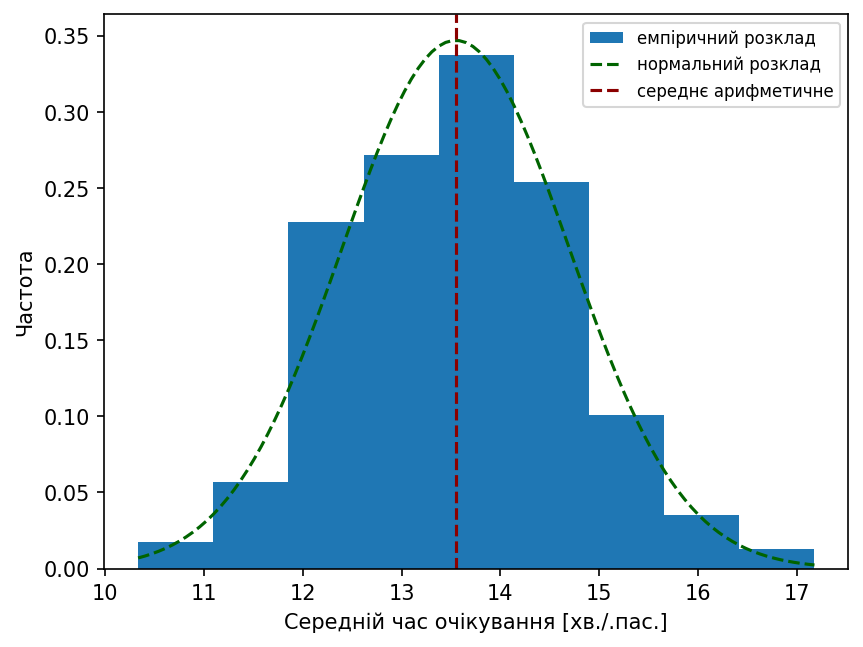

In [4]:
def plot_hist(res):
    xs = np.linspace(min(res), max(res), 100)
    params = ss.norm.fit(res)
    print(params)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(res, bins=9, density=True,
             label='емпіричний розклад')
    plt.plot(xs, ss.norm.pdf(xs, *params), linestyle='--', color='darkgreen',
             label='нормальний розклад')
    plt.axvline(res.mean(), linestyle='--', color='darkred',
                label='середнє арифметичне')
    plt.xlabel('Середній час очікування [хв./.пас.]')
    plt.ylabel('Частота')
    plt.legend(fontsize=8, loc='upper right')
    plt.show()

plot_hist(res)

In [5]:
def needed(xs, alpha=0.05):
    mean = xs.mean()
    var = xs.var()
    u_alpha = ss.norm.ppf(1 - alpha)
    return var * u_alpha**2 / (alpha * mean)**2

needed(res)

7.8008225564812905

## Run GA

In [7]:
N = 10

winners = []
for iter in range(30):
    print(iter + 1)
    g = ga.GA()
    g.chromosome_size = len(avtovokzal.lines), 7
    g.population_size = 100
    g.generations = 20
    g.crossover_probability = 0.5
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = lambda s: fitness_function(s).mean()
    winner = g.run()
    winners.append(winner[1])
    print()

1
winner #1 ([13, 18, 26, 13, 6], (12.616986780490627, <genetics.chromosome.Chromosome object at 0x1274a6230>))
winner #2 ([13, 18, 26, 13, 6], (12.405304227388646, <genetics.chromosome.Chromosome object at 0x1274dc970>))
winner #3 ([13, 18, 26, 9, 17], (12.553068869857395, <genetics.chromosome.Chromosome object at 0x1274dd3f0>))
winner #4 ([13, 22, 15, 8, 1], (12.42910185639798, <genetics.chromosome.Chromosome object at 0x1274dd450>))
winner #5 ([12, 18, 26, 17, 11], (12.428489334863102, <genetics.chromosome.Chromosome object at 0x12727ca90>))
winner #6 ([13, 22, 15, 8, 1], (12.23485674601231, <genetics.chromosome.Chromosome object at 0x1274dd450>))
winner #7 ([12, 18, 26, 17, 11], (12.335271567685691, <genetics.chromosome.Chromosome object at 0x1274a7ca0>))
winner #8 ([12, 18, 26, 17, 11], (12.139319467838027, <genetics.chromosome.Chromosome object at 0x12727df00>))
winner #9 ([12, 18, 26, 17, 11], (12.05400100227433, <genetics.chromosome.Chromosome object at 0x1274023e0>))
winner #1

In [8]:
np.array(winners).tofile('node_results/node30x20-2.txt', sep=',', format='%s')

## Analyze results

In [6]:
xs = np.fromfile('node_results/node30x20-2.txt', sep=',').reshape((30, 20))

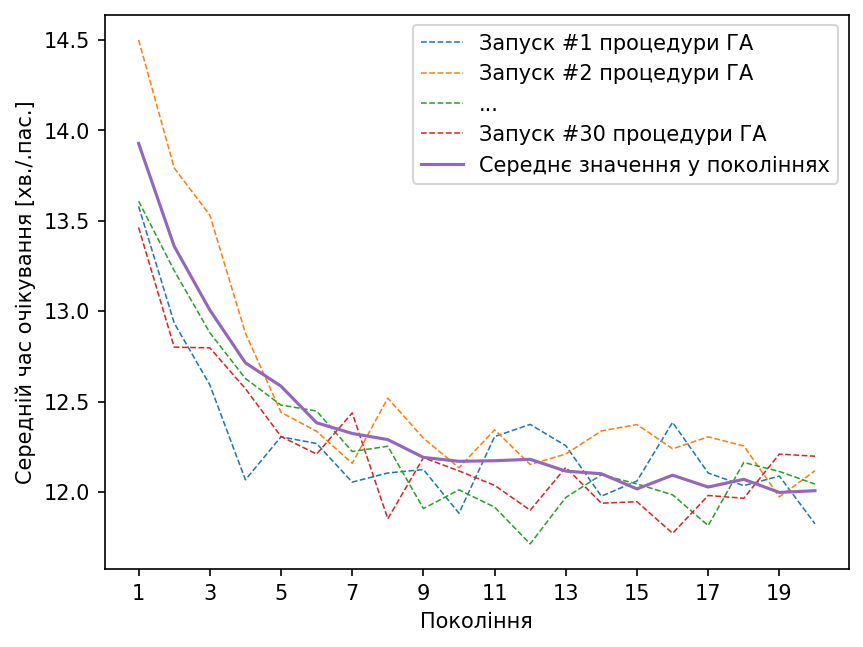

In [7]:
plt.figure(dpi=150)
plt.plot(range(1, 21), xs[9], lw=0.75, label=f'Запуск #1 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[10], lw=0.75, label=f'Запуск #2 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[11], lw=0.75, label=f'...', linestyle='--')
plt.plot(range(1, 21), xs[28], lw=0.75, label=f'Запуск #30 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Покоління')
plt.xticks(range(1,21, 2))
plt.legend()
plt.show()

In [13]:
# [20, 15, 13, 22, 8]     11.55858796423957
# [20, 16, 13, 24, 10]    11.595696434974496
# [17, 18, 11, 22, 16]    11.572283921964866
# [20, 15, 9, 22, 8]      11.692834150460332
# [13, 17, 1, 18, 6]      11.649208488695379
# [17, 12, 16, 19, 13]    11.622019927874137
# [16, 11, 9, 18, 12]     11.617900952294415
# [17, 19, 11, 22, 10]    11.646808720370387

In [8]:
schedules = [
    [20, 15, 13, 22, 8],
    [20, 16, 13, 24, 10],
    [17, 18, 11, 22, 16],
    [20, 15, 9, 22, 8],
    [13, 17, 1, 18, 6],
    [17, 12, 16, 19, 13],
    [16, 11, 9, 18, 12],
    [17, 19, 11, 22, 10]
]

N = 300
bests = [
    fitness_function(schedule)
    for schedule in schedules
]

In [9]:
print(res.mean())
for idx in range(len(schedules)):
    print(idx, schedules[idx], bests[idx].mean())

13.546880655982498
0 [20, 15, 13, 22, 8] 12.670304409045375
1 [20, 16, 13, 24, 10] 12.90079275463621
2 [17, 18, 11, 22, 16] 12.680889356163881
3 [20, 15, 9, 22, 8] 12.656951205027154
4 [13, 17, 1, 18, 6] 12.946967632479668
5 [17, 12, 16, 19, 13] 12.748934223566318
6 [16, 11, 9, 18, 12] 12.576995711116483
7 [17, 19, 11, 22, 10] 12.744795570527579


(13.546880655982498, 1.1501440895006747) (12.576995711116483, 1.1087421430093276)


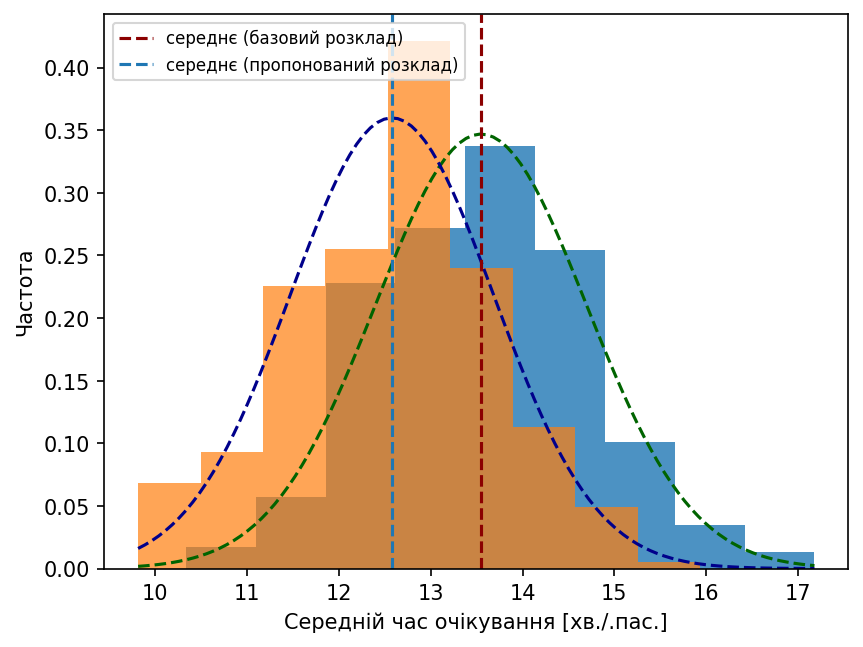

In [12]:
def plot_hist2(res1, res2):
    xs = np.linspace(min(res1.min(), res2.min()),
                     max(res1.max(), res2.max()), 100)
    params1, params2 = ss.norm.fit(res1), ss.norm.fit(res2)
    print(params1, params2)
    fig = plt.figure(dpi=150)
    # ax = fig.add_subplot(1, 1, 1)
    plt.hist(res1, density=True, bins=9, alpha=0.8
            #  label='емпіричний розклад (базовий)'
             )
    plt.hist(res2, density=True, bins=9, alpha=0.7
            #  label='емпіричний розклад (пропонований)'
             )
    plt.plot(xs, ss.norm.pdf(xs, *params1), linestyle='--', color='darkgreen',
            #  label='нормальний розклад (базовий)'
             )
    plt.plot(xs, ss.norm.pdf(xs, *params2), linestyle='--', color='darkblue',
            #  label='нормальний розклад (пропонований)'
             )
    
    plt.axvline(res1.mean(), linestyle='--', color='darkred',
                label='середнє (базовий розклад)')
    plt.axvline(res2.mean(), linestyle='--', #color='orange',
                label='середнє (пропонований розклад)')

    plt.xlabel('Середній час очікування [хв./.пас.]')
    plt.ylabel('Частота')
    plt.legend(fontsize=8, loc='upper left')
    plt.show()

plot_hist2(res, bests[6])

In [13]:
t0, t1 = res.mean(), bests[6].mean()
(t0 - t1) / t0 * 100

7.159470652291455